# This Notebook helps to create a dataset in the cocoformat and also has a visualization with with both coco and detectron API

Reference:
https://www.kaggle.com/code/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !rm -rf /content/uw-madison-gi-tract-image-segmentation

In [2]:
!unzip -qq /content/drive/MyDrive/UW_Madison_segmentation/train.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [3]:
!unzip -qq /content/drive/MyDrive/UW_Madison_segmentation/train.csv.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [4]:
!mkdir working

In [5]:
!pwd

/content


In [6]:
import pycocotools
from pycocotools import mask

In [7]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [8]:
import json
import numpy as np
import pycocotools.mask as mask_util
from skimage import measure
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import random
from itertools import groupby
import itertools
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

In [9]:
# creating a dataframe
path ="/content/uw-madison-gi-tract-image-segmentation/"
# path ="../projet 8/"
# path ="../input/uw-madison-gi-tract-image-segmentation/"

In [10]:
dataset_path = os.path.abspath(path) 
csv_path = os.path.abspath(path+"train.csv")
df = pd.read_csv(csv_path)

def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")[0]
    # returning the first file, though it will always hold one file.
    return file

# df["segmentation"] = df["segmentation"].astype("str")
df["case_id"] = df["id"].apply(lambda x: x.split("_")[0][4:])
df["day_id"] = df["id"].apply(lambda x: x.split("_")[1][3:])
df["slice_id"] = df["id"].apply(lambda x: x.split("_")[-1])
df["path"] = df["id"].apply(lambda x: fetch_file_from_id(dataset_path, x))
df['path']=df.path.astype('str')
df['case_id']=df.case_id.astype('str')
df['slice_id']=df.slice_id.astype('str')
df["filename"] = df["path"].apply(lambda x: x.split('/')[-1])
df['unique_filename']  = df.apply(lambda row: str(row.case_id) +'_'+ str(row.day_id)+'_'+str(row.filename), axis=1)
df["height"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
df["width"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")
df['size'] =df['height'].astype(str) +'x'+ df['width'].astype(str)



df.sample(5)

id        class  \
48733   case147_day18_slice_0005  small_bowel   
88792   case121_day16_slice_0110  small_bowel   
82568    case81_day30_slice_0003      stomach   
36493   case113_day16_slice_0101  small_bowel   
108493    case41_day0_slice_0117  small_bowel   

                                             segmentation case_id day_id  \
48733                                                 NaN     147     18   
88792   19566 5 19589 7 19831 8 19853 11 20096 11 2011...     121     16   
82568                                                 NaN      81     30   
36493   31146 5 31505 7 31864 9 32223 10 32583 10 3294...     113     16   
108493                                                NaN      41      0   

       slice_id                                               path  \
48733      0005  /content/uw-madison-gi-tract-image-segmentatio...   
88792      0110  /content/uw-madison-gi-tract-image-segmentatio...   
82568      0003  /content/uw-madison-gi-tract-image-segmentatio...   
36493      0101  /content/uw-madison-gi-tract-image-segmentatio...   
108493     0117  /content/uw-madison-gi-tract-image-segmentatio...   

                                filename  \
48733   slice_0005_266_266_1.50_1.50.png   
88792   slice_0110_266_266_1.50_1.50.png   
82568   slice_0003_266_266_1.50_1.50.png   
36493   slice_0101_360_310_1.50_1.50.png   
108493  slice_0117_360_310_1.50_1.50.png   

                                unique_filename  height  width     size  
48733   147_18_slice_0005_266_266_1.50_1.50.png     266    266  266x266  
88792   121_16_slice_0110_266_266_1.50_1.50.png     266    266  266x266  
82568    81_30_slice_0003_266_266_1.50_1.50.png     266    266  266x266  
36493   113_16_slice_0101_360_310_1.50_1.50.png     360    310  360x310  
108493    41_0_slice_0117_360_310_1.50_1.50.png     360    310  360x310

In [11]:
df.columns

Index(['id', 'class', 'segmentation', 'case_id', 'day_id', 'slice_id', 'path',
       'filename', 'unique_filename', 'height', 'width', 'size'],
      dtype='object')

In [12]:
# Remove misslabeled training data
df = df[(df['case_id']!=7)|(df['case_id']!=0)].reset_index(drop=True)
df = df[(df['case_id']!=81)|(df['case_id']!=30)].reset_index(drop=True)

In [13]:
df_with_mask = df[df['segmentation'].notnull()].copy() 
df_with_mask["segmentation"] = df["segmentation"].astype("str")
df_with_mask = df_with_mask.reset_index(drop=True)    

In [14]:

df_with_mask.head()

id    class  \
0  case123_day20_slice_0065  stomach   
1  case123_day20_slice_0066  stomach   
2  case123_day20_slice_0067  stomach   
3  case123_day20_slice_0068  stomach   
4  case123_day20_slice_0069  stomach   

                                        segmentation case_id day_id slice_id  \
0  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...     123     20     0065   
1  27561 8 27825 11 28090 13 28355 14 28620 15 28...     123     20     0066   
2  15323 4 15587 8 15852 10 16117 11 16383 12 166...     123     20     0067   
3  14792 5 15056 9 15321 11 15587 11 15852 13 161...     123     20     0068   
4  14526 6 14789 12 15054 14 15319 16 15584 17 15...     123     20     0069   

                                                path  \
0  /content/uw-madison-gi-tract-image-segmentatio...   
1  /content/uw-madison-gi-tract-image-segmentatio...   
2  /content/uw-madison-gi-tract-image-segmentatio...   
3  /content/uw-madison-gi-tract-image-segmentatio...   
4  /content/uw-madison-gi-tract-image-segmentatio...   

                           filename                          unique_filename  \
0  slice_0065_266_266_1.50_1.50.png  123_20_slice_0065_266_266_1.50_1.50.png   
1  slice_0066_266_266_1.50_1.50.png  123_20_slice_0066_266_266_1.50_1.50.png   
2  slice_0067_266_266_1.50_1.50.png  123_20_slice_0067_266_266_1.50_1.50.png   
3  slice_0068_266_266_1.50_1.50.png  123_20_slice_0068_266_266_1.50_1.50.png   
4  slice_0069_266_266_1.50_1.50.png  123_20_slice_0069_266_266_1.50_1.50.png   

   height  width     size  
0     266    266  266x266  
1     266    266  266x266  
2     266    266  266x266  
3     266    266  266x266  
4     266    266  266x266

In [ ]:
# df_with_mask = pd.read_csv('/content/drive/MyDrive/UW_Madison_segmentation/df_with_mask.csv')

In [ ]:
# df_with_mask.to_csv('/content/drive/MyDrive/UW_Madison_segmentation/df_with_mask.csv')

In [15]:
df_with_mask[df_with_mask['id']=='case121_day0_slice_0107']

id        class  \
26418  case121_day0_slice_0107  large_bowel   
26419  case121_day0_slice_0107  small_bowel   

                                            segmentation case_id day_id  \
26418  16886 6 17148 13 17410 19 17673 30 17936 37 18...     121      0   
26419  21709 4 21972 11 22238 16 22503 21 22769 23 23...     121      0   

      slice_id                                               path  \
26418     0107  /content/uw-madison-gi-tract-image-segmentatio...   
26419     0107  /content/uw-madison-gi-tract-image-segmentatio...   

                               filename  \
26418  slice_0107_266_266_1.50_1.50.png   
26419  slice_0107_266_266_1.50_1.50.png   

                              unique_filename  height  width     size  
26418  121_0_slice_0107_266_266_1.50_1.50.png     266    266  266x266  
26419  121_0_slice_0107_266_266_1.50_1.50.png     266    266  266x266

In [ ]:
df_with_mask.shape

(33913, 12)

In [16]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def create_coco_format_json(data_frame, classes, filepaths):
    images = []
    annotations = []
    categories = []
    count = 0
    
    # Additing categories
    for idx, class_ in enumerate(classes):
        categories.append(
            { 
                "id": idx,
                "name": class_
            }
        )
    i = 0
    for filepath in tqdm(filepaths):
        i += 1   
        image_id = i     
        file_id = ('_'.join((filepath.split("/")[-3] + "_" + filepath.split("/")[-1]).split("_")[:-4]))
        height_slice = int(filepath.split("/")[-1].split("_")[3])
        width_slice = int(filepath.split("/")[-1].split("_")[2])
        ids = data_frame.index[data_frame['id'] == file_id].tolist()
        # file_name = '/'.join(filepath.split("/")[2:])
        file_name = '/'.join(filepath.split("/")[3:])
        # print('/'.join(filepath.split("/")[2:]))
        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    # "id":file_id,
                    "id": image_id,
                    "file_id":file_id,#add id of the dataframe
                    "width":width_slice,
                    "height":height_slice,
                    "file_name": filepath
                }
            )
            for idx in ids:
                mk = rle_decode(data_frame.iloc[idx]['segmentation'], (height_slice, width_slice))
                ys, xs = np.where(mk)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)              
                contours,hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
                for id_, contour in enumerate(contours):
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc =binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation':enc, 
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':image_id, 
                        'category_id':classes.index(data_frame.iloc[idx]['class']), 
                        'iscrowd':0, 
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1        
    # creating the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format

In [ ]:
# Creation of train test split
train_df, test_df = train_test_split(df_with_mask, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(train_df.head())
print("\n \nNumber of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))


 
Number of Train Images:27130
Number of Test Images:6783


In [ ]:
train_df.to_csv('/content/drive/MyDrive/UW_Madison_segmentation/train_df.csv')
test_df.to_csv('/content/drive/MyDrive/UW_Madison_segmentation/test_df.csv')

In [18]:
test_df = pd.read_csv('/content/drive/MyDrive/UW_Madison_segmentation/test_df.csv')
train_df = pd.read_csv('/content/drive/MyDrive/UW_Madison_segmentation/train_df.csv')

test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [21]:
indexes = test_df['id'].value_counts().sort_values(ascending=False).to_frame().iloc[:200,:].index
tmp_df = test_df[test_df['id'].isin(indexes)]
# tmp_df = test_df.sample(200)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.sample(5)

Unnamed: 0                        id        class  \
418        6734   case32_day18_slice_0111  small_bowel   
134        2345  case124_day20_slice_0066      stomach   
314        5079    case11_day0_slice_0061  large_bowel   
376        6019  case117_day13_slice_0056  large_bowel   
367        5873   case121_day0_slice_0118  large_bowel   

                                          segmentation  case_id  day_id  \
418  19045 6 19309 9 19574 10 19839 11 20103 13 203...       32      18   
134  33680 7 33944 12 34209 14 34474 16 34740 17 35...      124      20   
314  47419 6 47777 13 47795 7 48136 28 48496 29 488...       11       0   
376  34723 3 34996 8 35270 11 35544 14 35662 8 3581...      117      13   
367  18482 5 18745 11 19010 14 19275 15 19541 15 19...      121       0   

     slice_id                                               path  \
418       111  /content/uw-madison-gi-tract-image-segmentatio...   
134        66  /content/uw-madison-gi-tract-image-segmentatio...   
314        61  /content/uw-madison-gi-tract-image-segmentatio...   
376        56  /content/uw-madison-gi-tract-image-segmentatio...   
367       118  /content/uw-madison-gi-tract-image-segmentatio...   

                             filename  \
418  slice_0111_266_266_1.50_1.50.png   
134  slice_0066_266_266_1.50_1.50.png   
314  slice_0061_360_310_1.50_1.50.png   
376  slice_0056_276_276_1.63_1.63.png   
367  slice_0118_266_266_1.50_1.50.png   

                             unique_filename  height  width     size  
418   32_18_slice_0111_266_266_1.50_1.50.png     266    266  266x266  
134  124_20_slice_0066_266_266_1.50_1.50.png     266    266  266x266  
314    11_0_slice_0061_360_310_1.50_1.50.png     360    310  360x310  
376  117_13_slice_0056_276_276_1.63_1.63.png     276    276  276x276  
367   121_0_slice_0118_266_266_1.50_1.50.png     266    266  266x266

In [22]:
classes = ['small_bowel', 'large_bowel', 'stomach']
tmp_json = create_coco_format_json(tmp_df, classes, tmp_df['path'].tolist())

100%|██████████| 420/420 [00:13<00:00, 30.87it/s]


In [ ]:
# Code taken from: https://stackoverflow.com/a/65151218/12890869
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

with open('working/tmp_json.json', 'w', encoding='utf-8') as f:
    json.dump(tmp_json, f, ensure_ascii=True, indent=4, default=np_encoder)        

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


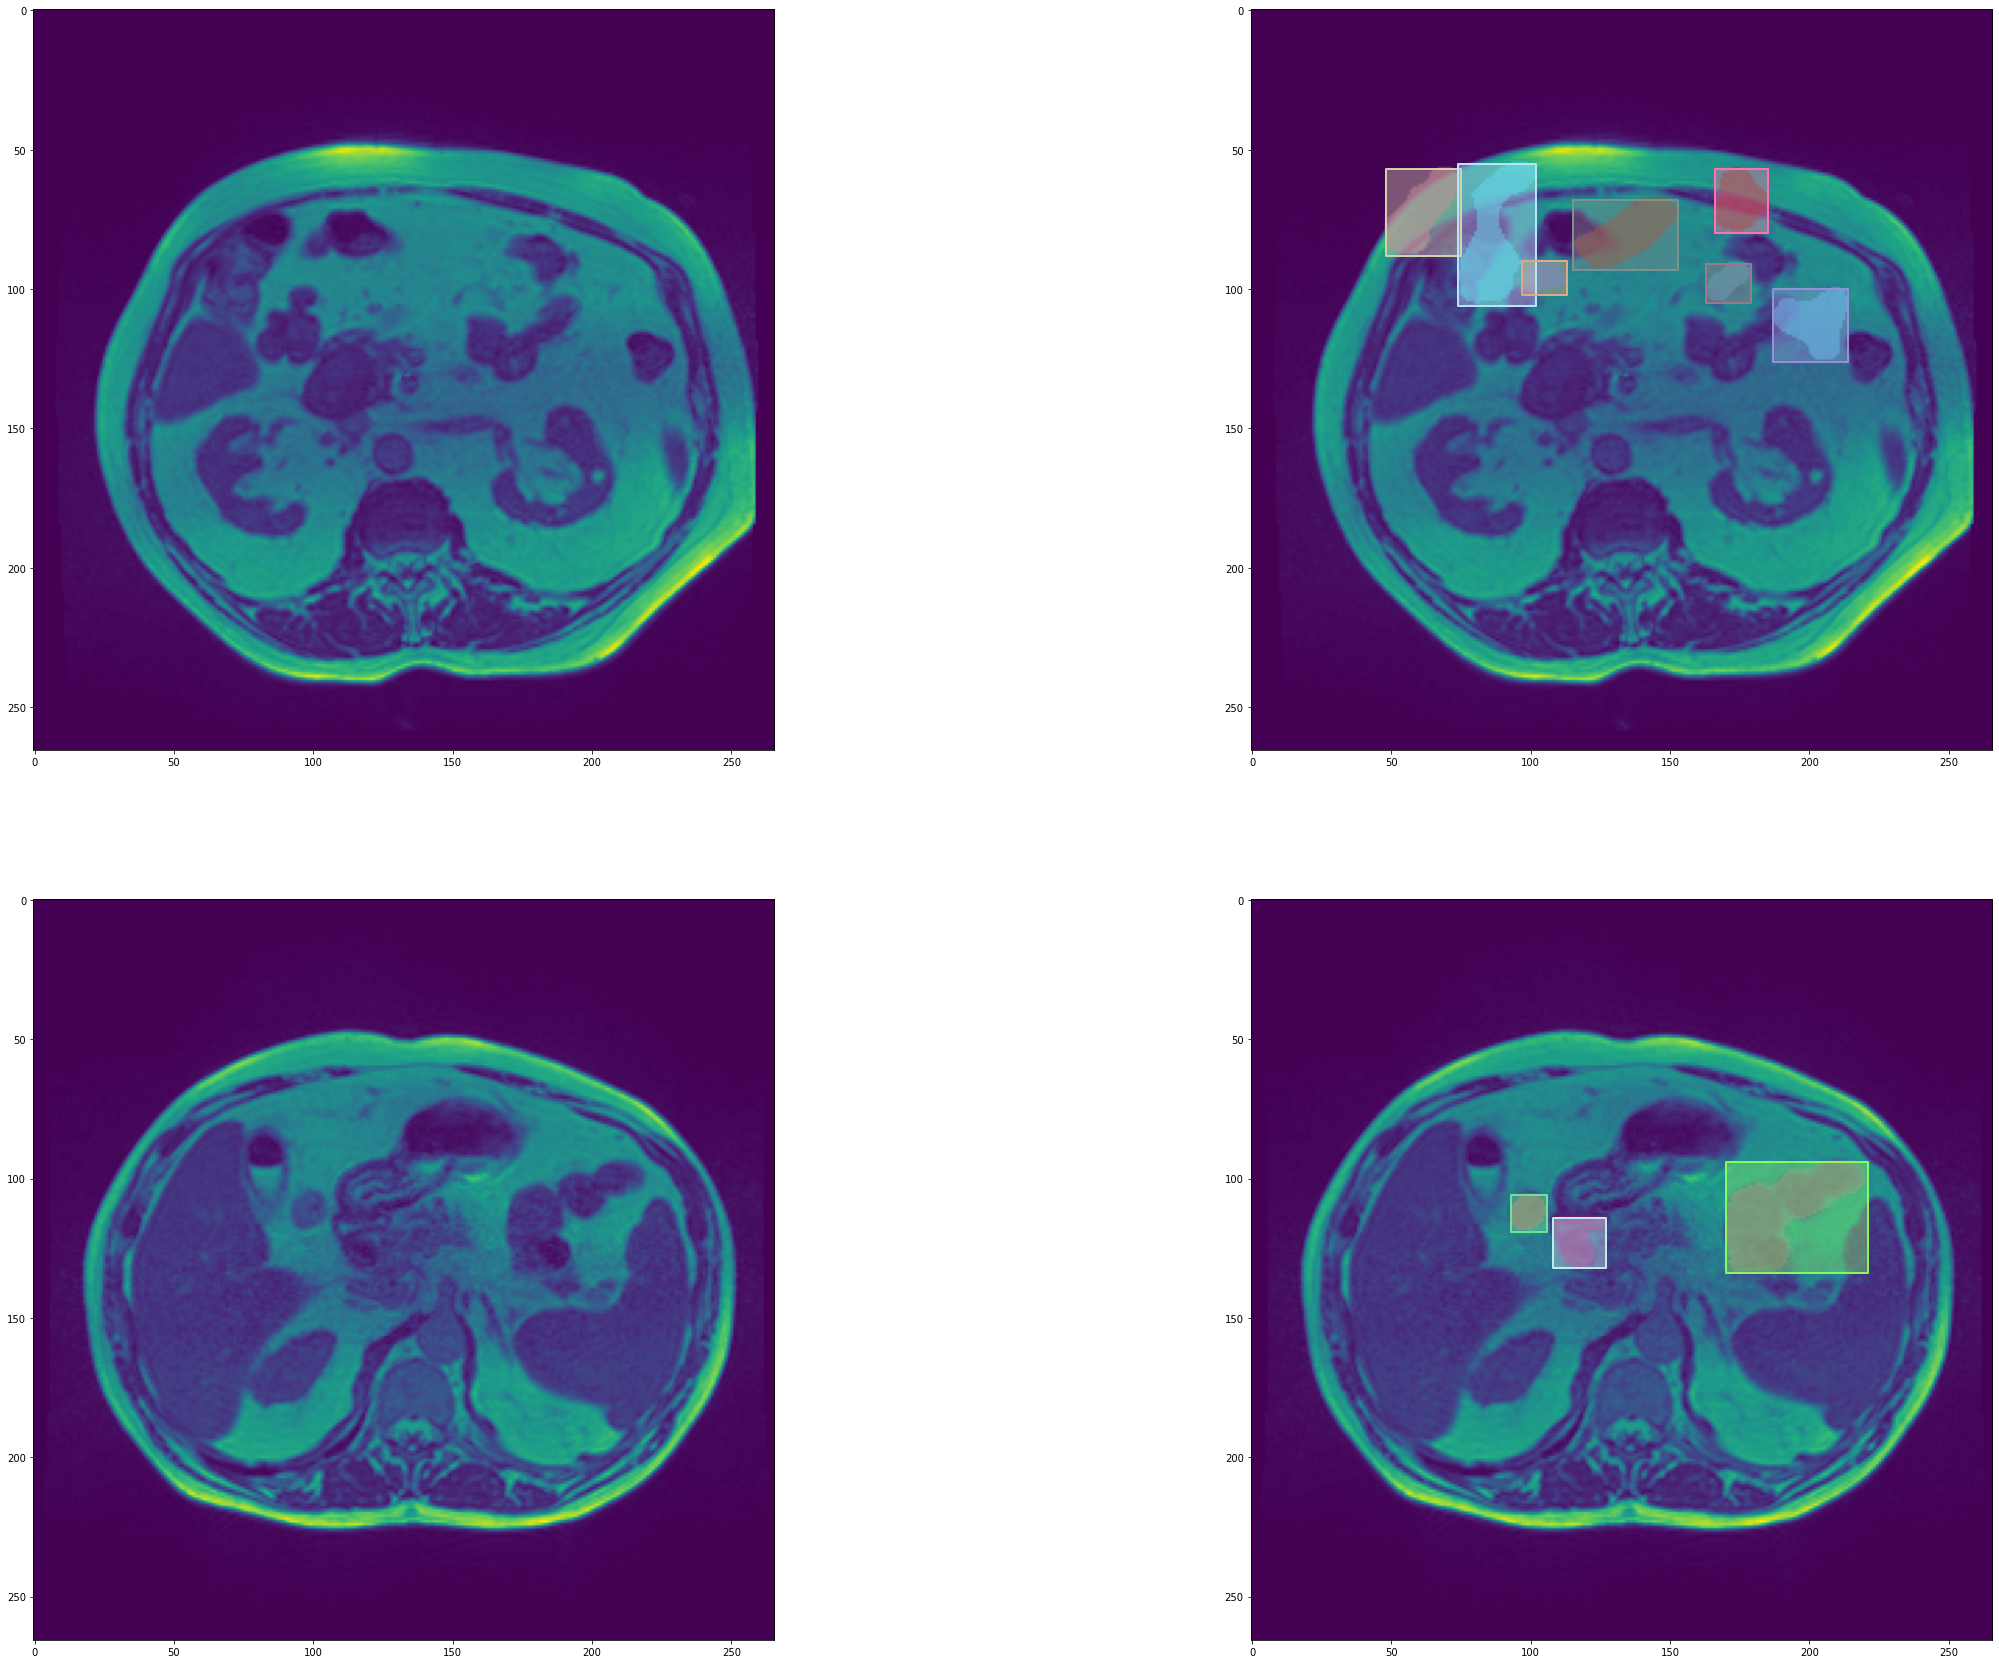

In [24]:
annFile = Path(f'/content/working/tmp_json.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()


imgs = coco.loadImgs(imgIds[0:2])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
#     I = Image.open(img['file_name'])
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [25]:

import pandas as pd
info = coco.dataset

for k, v in info.items():
    if isinstance(v, int):
        info[k] = [v]
dataframe = pd.DataFrame.from_dict(info, orient='index')
dataframe

0     \
categories                    {'id': 0, 'name': 'small_bowel'}   
images       {'id': 1, 'file_id': 'case7_day0_slice_0094', ...   
annotations  {'segmentation': {'counts': [49850, 5, 260, 7,...   

                                                          1     \
categories                    {'id': 1, 'name': 'large_bowel'}   
images       {'id': 2, 'file_id': 'case125_day15_slice_0075...   
annotations  {'segmentation': {'counts': [44226, 6, 258, 10...   

                                                          2     \
categories                        {'id': 2, 'name': 'stomach'}   
images       {'id': 3, 'file_id': 'case36_day6_slice_0054',...   
annotations  {'segmentation': {'counts': [12845, 7, 257, 11...   

                                                          3     \
categories                                                None   
images       {'id': 4, 'file_id': 'case24_day0_slice_0062',...   
annotations  {'segmentation': {'counts': [19778, 4, 257, 14...   

                                                          4     \
categories                                                None   
images       {'id': 5, 'file_id': 'case63_day18_slice_0093'...   
annotations  {'segmentation': {'counts': [43457, 4, 260, 7,...   

                                                          5     \
categories                                                None   
images       {'id': 6, 'file_id': 'case16_day0_slice_0077',...   
annotations  {'segmentation': {'counts': [25902, 1, 261, 6,...   

                                                          6     \
categories                                                None   
images       {'id': 7, 'file_id': 'case154_day17_slice_0058...   
annotations  {'segmentation': {'counts': [30674, 1, 264, 4,...   

                                                          7     \
categories                                                None   
images       {'id': 8, 'file_id': 'case35_day13_slice_0060'...   
annotations  {'segmentation': {'counts': [24848, 7, 258, 9,...   

                                                          8     \
categories                                                None   
images       {'id': 9, 'file_id': 'case129_day20_slice_0070...   
annotations  {'segmentation': {'counts': [45334, 10, 251, 1...   

                                                          9     ...  \
categories                                                None  ...   
images       {'id': 10, 'file_id': 'case11_day0_slice_0067'...  ...   
annotations  {'segmentation': {'counts': [28844, 4, 260, 9,...  ...   

                                                          1901  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [48772, 8, 301, 10...   

                                                          1902  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [54666, 3, 259, 10...   

                                                          1903  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [15794, 4, 260, 8,...   

                                                          1904  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [21660, 5, 259, 11...   

                                                          1905  \
categories                                                None   
images                                                    None   
annotations  {'segmentation': {'counts': [37858, 5, 260, 8,...   

                                                          1906 

In [ ]:
classes = ['small_bowel', 'large_bowel', 'stomach']

train_json = create_coco_format_json(train_df, classes, train_df['path'].tolist())
test_json = create_coco_format_json(test_df, classes, test_df['path'].tolist())

100%|██████████| 6783/6783 [02:39<00:00, 42.45it/s]


In [ ]:
with open('working/train_json.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4, default=np_encoder)

# with open('working/val_json.json', 'w', encoding='utf-8') as f:
#     json.dump(val_json, f, ensure_ascii=True, indent=4, default=np_encoder)    
    
with open('working/test_json.json', 'w', encoding='utf-8') as f:
    json.dump(test_json, f, ensure_ascii=True, indent=4, default=np_encoder)

In [26]:
# !cp '/content/drive/MyDrive/UW_Madison_segmentation/train_json.json' '/content/working/train_json.json'
# !cp '/content/drive/MyDrive/UW_Madison_segmentation/test_json.json' '/content/working/test_json.json'

In [ ]:
# !cp /content/working/train_json.json /content/drive/MyDrive/UW_Madison_segmentation/train_json.json
# !cp /content/working/test_json.json /content/drive/MyDrive/UW_Madison_segmentation/test_json.json

In [ ]:

# train_json = json.load(open('/content/drive/MyDrive/UW_Madison_segmentation/train_json.json', 'r'))
# test_json = json.load(open('/content/drive/MyDrive/UW_Madison_segmentation/test_json.json', 'r'))

train_json = json.load(open('/content/working/train_json.json', 'r'))
test_json = json.load(open('/content/working/test_json.json', 'r'))

In [27]:
MASK_TRAIN_DIR = '/content/working/'
IMAGE_TRAIN_DIR = '/content/uw-madison-gi-tract-image-segmentation/'
ANNOTATION_FILE_VAL = (MASK_TRAIN_DIR+'test_json.json')
ANNOTATION_FILE_TRAIN = (MASK_TRAIN_DIR+'train_json.json')

coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds() # Get all Categories ('horse','human' etc...)
imgIds_train = coco_train.getImgIds() # Get all image ID's (dict with path and annotations)
imgDict_train = coco_train.loadImgs(imgIds_train) # Func to load images from path
print(len(imgIds_train) , len(catIds_train))

coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds()
imgIds_val = coco_val.getImgIds()
imgDict_val = coco_val.loadImgs(imgIds_val)
print(len(imgIds_val) , len(catIds_val))

loading annotations into memory...
Done (t=3.14s)
creating index...
index created!
27130 3
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
6783 3


In [28]:
path

'/content/uw-madison-gi-tract-image-segmentation/'

In [29]:
imgs = coco_train.loadImgs(imgIds_train[0:5])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    print(img['file_id'])
    I = Image.open(img['file_name'])
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco_train.getAnnIds(imgIds=[img['id']])
    anns = coco_train.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco_train.showAnns(anns, draw_bbox=True)

case129_day20_slice_0065
case133_day25_slice_0091
case32_day20_slice_0072
case11_day0_slice_0089
case113_day12_slice_0076


In [ ]:
# !rm -rf /content/working

In [ ]:
# !mkdir /content/working

In [ ]:
# !zip -qq -r /content/working.zip /content/working/

In [ ]:
# !cp /content/working.zip /content/drive/MyDrive/UW_Madison_segmentation/working.zip

In [ ]:
# def make_mask(df,imgIds,MASK_TRAIN_DIR,IMAGE_TRAIN_DIR,coco):
#   count = 0 
#   unfitted_image_dict = []
#   for ID in tqdm(imgIds):
#     file_path = df[df.index==ID].iloc[0]['path']
#     file_name = file_path.split("/")[-1:][0]
#     file_path = file_path.replace(file_name,'').replace(IMAGE_TRAIN_DIR,MASK_TRAIN_DIR)
#     sampleImgIds = coco.getImgIds(imgIds = [ID])
#     sampleImgDict = coco.loadImgs(sampleImgIds)[0]
#     annIds = coco.getAnnIds(imgIds=sampleImgDict['id'], 
#                                 iscrowd=0)
#     anns = coco.loadAnns(annIds)
#     # separating images with background as the only mask
#     if len(anns)==0:
#         unfitted_image_dict.append(sampleImgDict)
#     else:
#         mask = coco.annToMask(anns[0])
#         # unify all the masks provided
#         for i in (range(len(anns))):
#             mask = mask | coco.annToMask(anns[i])
#         mask = Image.fromarray(mask * 255 , mode = "L")
#         # save the mask
#         os.makedirs(file_path, exist_ok=True)
#         mask.save(file_path+file_name)
#         count = count + 1
#   print(count)


# make_mask(train_df,imgIds_train,MASK_TRAIN_DIR,IMAGE_TRAIN_DIR,coco_train)
# make_mask(test_df,imgIds_val,MASK_TRAIN_DIR,IMAGE_TRAIN_DIR,coco_val)

In [30]:
# use image size 128 for better results 
image_size = 128 
epochs = 10
batch_size = 8

In [31]:
# display COCO categories and supercategories
annFile = Path(f'/content/working/tmp_json.json')
coco = COCO(annFile)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
cats


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


[{'id': 0, 'name': 'small_bowel'},
 {'id': 1, 'name': 'large_bowel'},
 {'id': 2, 'name': 'stomach'}]

In [32]:
nms=[cat['name'] for cat in cats]
print(len(nms),'categories: \n{}\n'.format(' '.join(nms)))

3 categories: 
small_bowel large_bowel stomach



In [33]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('The class name is', getClassName(1, cats))

The class name is large_bowel


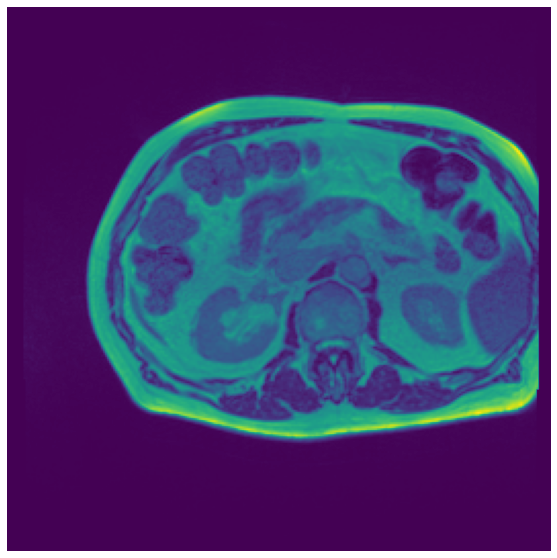

In [34]:
# load and display image
plt.figure(figsize=(10,10)) 
import skimage.io as io 
img = coco_train.loadImgs(imgIds_train[np.random.randint(0,len(imgIds_train))])[0] 
I = io.imread(img['file_name'])/255.0

# Or use url to load image
plt.axis('off') 
plt.imshow(I) 
plt.show( )

In [35]:
img

{'file_id': 'case85_day21_slice_0090',
 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case85/case85_day21/scans/slice_0090_266_266_1.50_1.50.png',
 'height': 266,
 'id': 26371,
 'width': 266}

In [38]:
# load and display instance annotations
plt.figure(figsize=(10,10))
plt.imshow(I); plt.axis('off')
annIds = coco_train.getAnnIds(imgIds=img['id'], catIds=catIds_train, iscrowd=None)
anns = coco_train.loadAnns(annIds)
coco_train.showAnns(anns)

In [39]:
########## ALl POSSIBLE COMBINATIONS ########
classes = ['small_bowel', 'large_bowel', 'stomach']

images = []
if classes!=None:
    # iterate for each individual class in the list
    for className in classes:
        # get all images containing given class
        catIds = coco_train.getCatIds(catNms=className)
        imgIds = coco_train.getImgIds(catIds=catIds)
        images += coco_train.loadImgs(imgIds)
else:
    imgIds = coco_train.getImgIds()
    images = coco_train.loadImgs(imgIds)
    
# Now, filter out the repeated images    
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 27130


In [ ]:
unique_images[0]

{'file_id': 'case66_day36_slice_0091',
 'file_name': '/content/uw-madison-gi-tract-image-segmentation/case66/case66_day36/scans/slice_0091_266_266_1.50_1.50.png',
 'height': 266,
 'id': 1,
 'width': 266}

Normal Mask

In [40]:
#### GENERATE A SEGMENTATION MASK ####
filterClasses =  ['small_bowel', 'large_bowel', 'stomach']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco_train.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

Unique pixel values in the mask are: [0. 1. 3.]


Binary Masking

In [41]:
#### GENERATE BINARY MASK ####

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco_train.annToMask(anns[i]), mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

Unique pixel values in the mask are: [0. 1.]


In [42]:
def filterDataset( classes=None, json_file=None):    
    # initialize COCO api for instance annotations
    annFile = json_file
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [43]:
classes = ['small_bowel', 'large_bowel', 'stomach']

images_tmp, dataset_size_tmp, coco = filterDataset( classes,  '/content/working/tmp_json.json')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [44]:
classes = ['small_bowel', 'large_bowel', 'stomach']
images_train, dataset_size_train, coco_train = filterDataset( classes,  '/content/working/train_json.json')
images_test, dataset_size_test, coco_val = filterDataset( classes,  '/content/working/test_json.json')

loading annotations into memory...
Done (t=2.93s)
creating index...
index created!
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [45]:
import skimage.io as io

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None


def getImage(imageObj,  input_image_size):
    # Read and normalize an image
    train_img = cv2.imread(imageObj['file_name'], cv2.IMREAD_ANYDEPTH)
    # Resize
    train_img = cv2.resize(train_img, (input_image_size))
    #normalize
    train_img = train_img.astype(np.float32) / 255.


    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img      
      


def getLevelsMask(image_id, classes, coco, catIds, input_image_size):
  #for each category , we get the x mask and add it to mask list
  res = []  
  mask = np.zeros((input_image_size[0],input_image_size[1]))
  for j,categorie in enumerate(catIds):
    annIds = coco.getAnnIds(image_id, catIds=categorie, iscrowd=None)
    anns = coco.loadAnns(annIds)
    mask = getNormalMask(image_id, classes, coco, categorie, input_image_size)
    # mask = getBinaryMask(image_id, coco, categorie, input_image_size)
    res.append( mask)
  return res

    
def getNormalMask(image_id, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(image_id, catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    # train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    


def getBinaryMask(image_id, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(image_id, catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    # train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco,  
                      input_image_size=(128,128), batch_size=8, mask_type='binary'):
    
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    c = 0       
    
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype(np.float32)
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype(np.float32)
        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0

            imageObj = images[i]
            image_id = imageObj['id']
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
              train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            if mask_type=="normal":
              # train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)     
              train_mask = getLevelsMask(image_id, classes, coco, catIds, input_image_size)  
                         
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            # mask[i-c] = train_mask
            mask[i-c,:,:,0] = train_mask[0]
            mask[i-c,:,:,1] = train_mask[1]
            mask[i-c,:,:,2] = train_mask[2]
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask    

In [80]:
batch_size = 16
input_image_size = (128,128)
mask_type = 'normal' 
classes = ['small_bowel', 'large_bowel', 'stomach']

In [81]:
tmp_generator =  dataGeneratorCoco(images_tmp, classes, coco,input_image_size, batch_size, mask_type)

In [82]:
train_generator = dataGeneratorCoco(images_train, classes, coco_train,input_image_size, batch_size, mask_type)
# valid_generator = dataGeneratorCoco(images_train, classes, coco_train,input_image_size, batch_size, mask_type)
test_generator = dataGeneratorCoco(images_test, classes, coco_val,input_image_size, batch_size, mask_type)

In [50]:
img_s, mask_s = next(test_generator)
# img_s, mask_s = next(tmp_generator)
print(img_s.shape)
print(mask_s.shape)
img = img_s[0]
h, w, c = img.shape
# print(img_s[0])
# print(img['id'])
# print(img[0].shape)
print('width:  ', w)
print('height: ', h)
print('channel:', c)
# plt.imshow(img[0][:, :,0])
plt.imshow(img[:,:,0], cmap='gray')

(8, 128, 128, 3)
(8, 128, 128, 3)
width:   128
height:  128
channel: 3


In [ ]:
classes

['small_bowel', 'large_bowel', 'stomach']

In [ ]:
coco.getCatIds(catNms=classes)

[0, 1, 2]

(8, 128, 128, 3)
(8, 128, 128, 3)
width:   128
height:  128
channel: 3


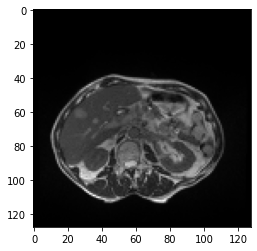

In [ ]:
img_s, mask_s = next(test_generator)
# img_s, mask_s = next(tmp_generator)
print(img_s.shape)
print(mask_s.shape)
img = img_s[0]
h, w, c = img.shape
# print(img_s[0])
# print(img['id'])
# print(img[0].shape)
print('width:  ', w)
print('height: ', h)
print('channel:', c)
# plt.imshow(img[0][:, :,0])
plt.imshow(img[:,:,0], cmap='gray')

In [51]:
img_s, mask_s = next(test_generator)


fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(nrows=len(img_s), ncols=2)
colors = ['yellow','green','red']
labels = [ "Small Bowel","Large Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])
flag=False
for i in range(1,7):

    images, mask = img_s[i], mask_s[i]
    sample_img=images/255.
    mask1=mask[:,:,0]
    mask2=mask[:,:,1]
    mask3=mask[:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img[:,:,0], cmap='gray')

    ax1 = fig.add_subplot(gs[i, 1])
    if(flag == False):
      flag= True
      ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
      ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
      plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


In [52]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl


img, mask = next(train_generator)


# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

index = 2
sample_img=img[index][:,:,0]
mask1=mask[index][:,:,0]
mask2=mask[index][:,:,1]
mask3=mask[index][:,:,2]

ax0 = fig.add_subplot(gs[0, 0])
im = ax0.imshow(sample_img, cmap='gray')

ax1 = fig.add_subplot(gs[0, 1])

ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

l0 = ax1.imshow(sample_img, cmap='gray')
l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
_ = [ax.set_axis_off() for ax in [ax0,ax1]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2,l3]]

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


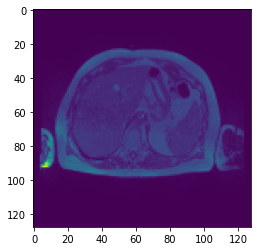

In [53]:
img = cv2.imread(images_tmp[1]['file_name'], cv2.IMREAD_ANYDEPTH)
dsize = (128, 128)
img = cv2.resize(img, dsize)
img = img.astype(np.float32) / 255.
# img = np.expand_dims(img, axis=-1)
plt.imshow(img)

In [54]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import NoNorm

def visualizeGenerator(gen):

    img_, mask_ = next(gen)
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                # print('image')
                # print(img_[j].shape)
                ax.imshow(img_[j][:,:,0],cmap='gray')
                # ax.imshow(img_[j],cmap='gray')
            else:
                ax.imshow(mask_[j])
                # print('mask')
                # print(mask_[j].shape)
                # ax.imshow(mask_[j][:,:,0])
                # ax.imshow(mask_[j][:,:,1])
                # ax.imshow(mask_[j][:,:,2])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


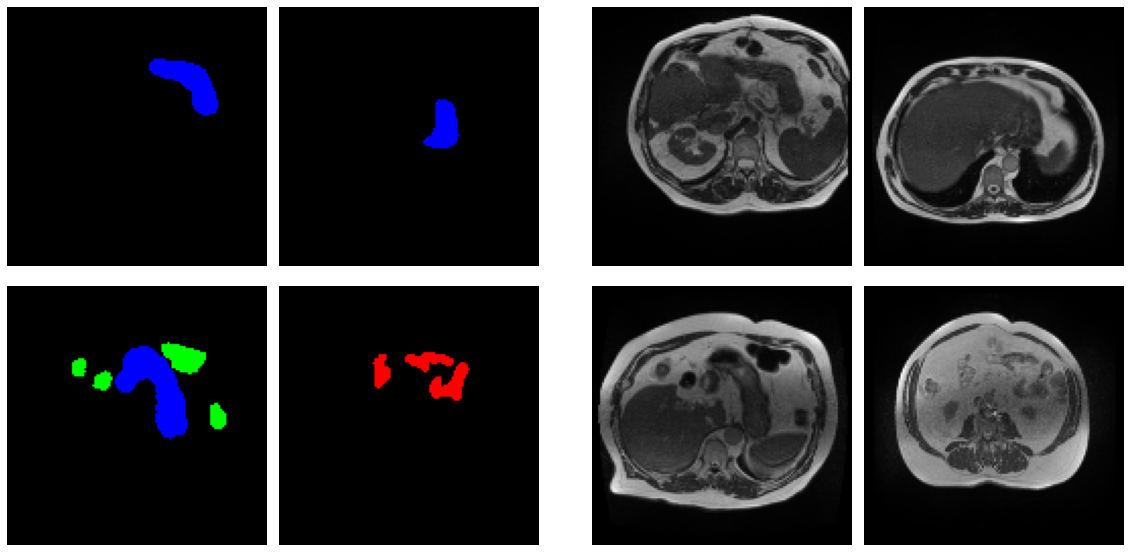

In [55]:
visualizeGenerator(train_generator)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


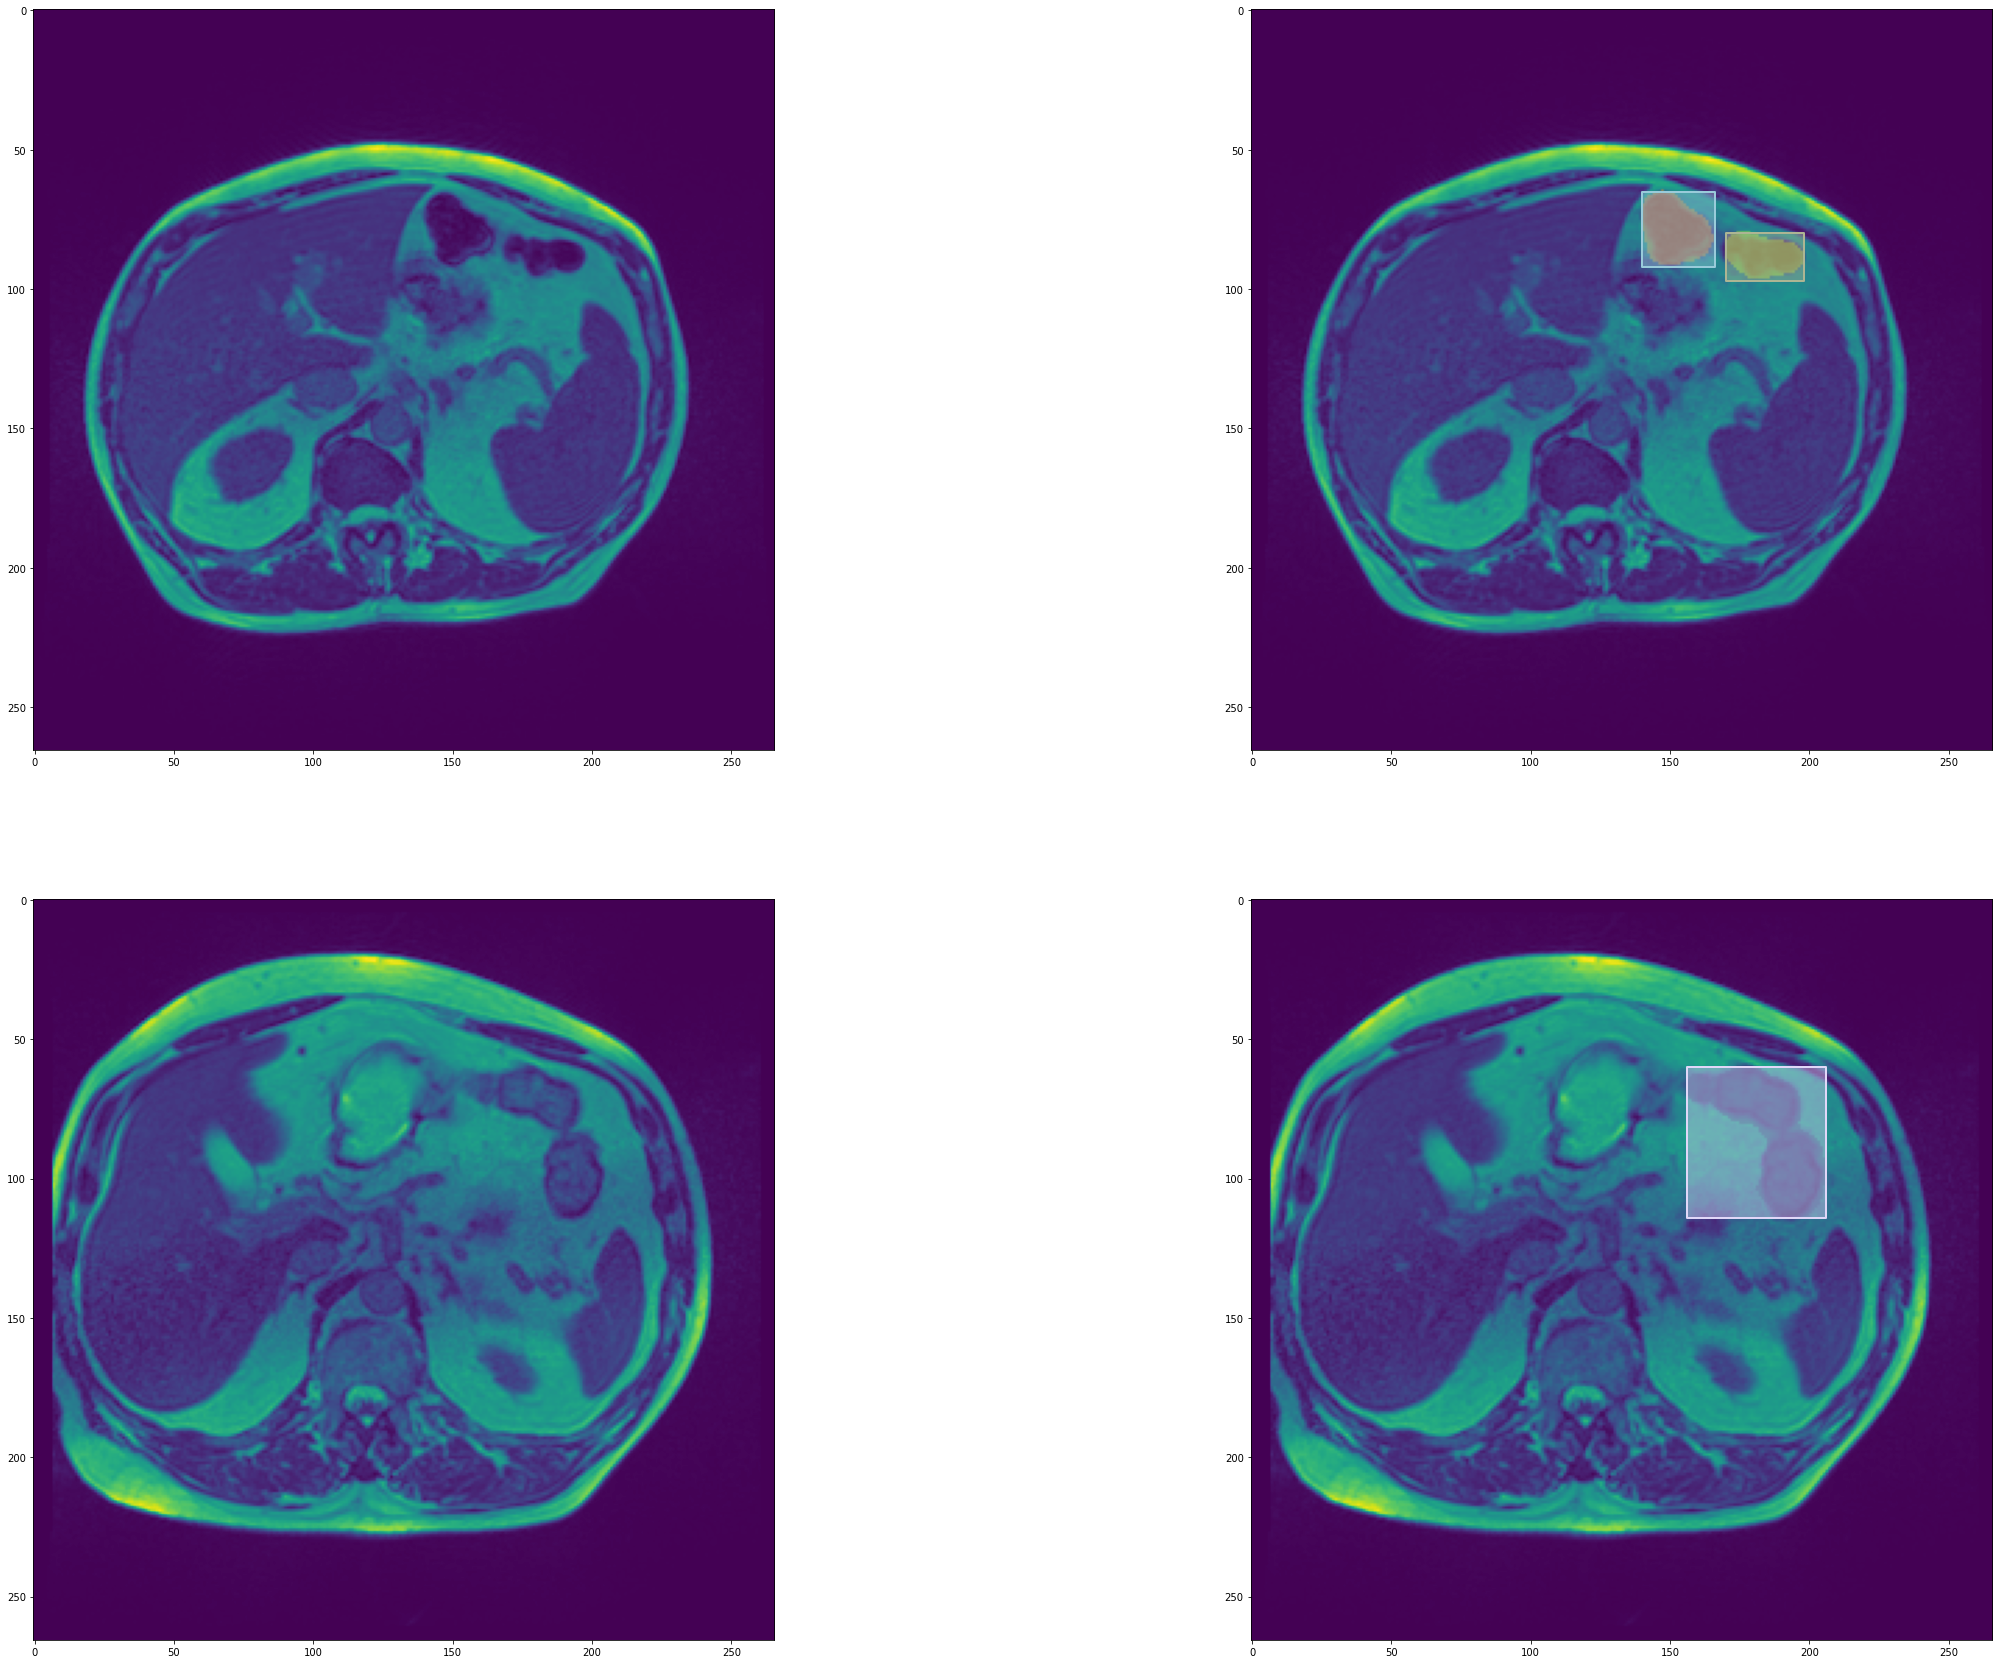

In [ ]:
annFile = Path(f'/content/working/tmp_json.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()


imgs = coco.loadImgs(imgIds[0:20])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
#     I = Image.open(img['file_name'])
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [150]:
from keras.preprocessing.image import ImageDataGenerator

def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    # _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(255*mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [152]:


augGeneratorArgs = dict(
                        featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        # fill_mode = 'reflect',
                        # data_format = 'channels_last',
                        # validation_split=0.2,


                        # rescale=1/255,
                        # rotation_range=20,
                        # width_shift_range=0.2,
                        # height_shift_range=0.2,
                        # shear_range=0.2,
                        # zoom_range=0.2,
                        # horizontal_flip=True,
                        # fill_mode='nearest',
                        # validation_split=0.2,
                        
                        
                        )

augm_tmp = augmentationsGenerator(tmp_generator, augGeneratorArgs)

augm_train = augmentationsGenerator(train_generator, augGeneratorArgs)
# augm_valid = augmentationsGenerator(valid_generator, augGeneratorArgs)
augm_test = augmentationsGenerator(test_generator, augGeneratorArgs)

In [148]:
visualizeGenerator(augm_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [59]:
! pip install --quiet segmentation-models

     |████████████████████████████████| 50 kB 7.0 MB/s 


In [60]:
! pip install --quiet  git+https://github.com/qubvel/segmentation_models

In [61]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [91]:
from keras import backend as K
from keras.losses import binary_crossentropy
# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [142]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import segmentation_models as sm


model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef]) 


In [143]:
steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_test // batch_size

In [ ]:
# steps_per_epoch = dataset_size_tmp // batch_size
# validation_steps = dataset_size_tmp // batch_size

In [144]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard,ModelCheckpoint

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

reduce_lr = ReduceLROnPlateau(factor=0.2,monitor='val_loss',verbose=1,patience=5, min_lr=0.001)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

early_stopping = EarlyStopping(monitor='loss',min_delta=0.0001, patience=5)

In [153]:
history = model.fit(

                    # train_generator,                    
                    # validation_data = test_generator,

                    augm_train,
                    validation_data = augm_test,

                    # tmp_generator,
                    # validation_data = tmp_generator,

                    validation_steps = validation_steps,  
                    steps_per_epoch = steps_per_epoch , 
                    epochs = epochs,

                    callbacks=[tb_callback,reduce_lr,early_stopping,checkpoint],

                    batch_size = batch_size,
                    # workers=4,
                    # use_multiprocessing=True

                    )

Epoch 1/10
1695/1695 [==============================] - ETA: 0s - loss: -16857.7344 - dice_coef: 1.2956 - iou_coef: 1.8648
Epoch 1: val_loss improved from inf to -20924.99805, saving model to UNET_model
INFO:tensorflow:Assets written to: UNET_model/assets
1695/1695 [==============================] - 560s 330ms/step - loss: -16857.7344 - dice_coef: 1.2956 - iou_coef: 1.8648 - val_loss: -20924.9980 - val_dice_coef: 1.1623 - val_iou_coef: 1.4158 - lr: 0.0010
Epoch 2/10
1695/1695 [==============================] - ETA: 0s - loss: -41324.1484 - dice_coef: 1.2920 - iou_coef: 1.8506
Epoch 2: val_loss improved from -20924.99805 to -42396.72266, saving model to UNET_model
INFO:tensorflow:Assets written to: UNET_model/assets
1695/1695 [==============================] - 561s 331ms/step - loss: -41324.1484 - dice_coef: 1.2920 - iou_coef: 1.8506 - val_loss: -42396.7227 - val_dice_coef: 1.1631 - val_iou_coef: 1.4149 - lr: 0.0010
Epoch 3/10
1695/1695 [==============================] - ETA: 0s - loss:

In [154]:
print(history.history.keys())

dict_keys(['loss', 'dice_coef', 'iou_coef', 'val_loss', 'val_dice_coef', 'val_iou_coef', 'lr'])


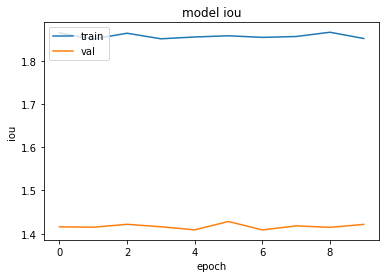

In [155]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for IOU
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/UW_Madison_segmentation/model_yield_augm.h5')
# model.save('/content/model.h5')

In [137]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/UW_Madison_segmentation/model_yield_augm.h5', custom_objects={"iou_coef": iou_coef,'dice_coef':dice_coef,'bce_dice_loss':bce_dice_loss,'dice_loss':dice_loss})


In [ ]:
len(images_test)

6783

In [99]:
submission_df = test_df
submission_df["segmentation"]=''
submission_df=submission_df.rename(columns={"segmentation":"prediction"})
submission_df= submission_df.drop(columns=['case_id','day_id',	'slice_id',	'path',	'filename'	,'unique_filename',	'height',	'width',	'size','Unnamed: 0'])
submission_df.head()

id        class prediction
0  case113_day16_slice_0109  small_bowel           
1  case156_day11_slice_0120  small_bowel           
2  case143_day23_slice_0063  small_bowel           
3    case9_day20_slice_0050      stomach           
4    case36_day6_slice_0074  large_bowel

2870
case125_day15_slice_0102
/content/uw-madison-gi-tract-image-segmentation/case125/case125_day15/scans/slice_0102_266_266_1.50_1.50.png
Series([], Name: path, dtype: object)
407
case2_day3_slice_0058
/content/uw-madison-gi-tract-image-segmentation/case2/case2_day3/scans/slice_0058_266_266_1.50_1.50.png
Series([], Name: path, dtype: object)


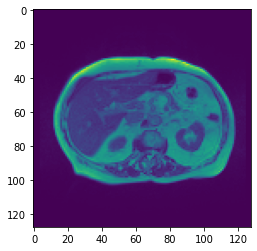

In [100]:
i=0
for im in images_test:
  print(im['id'])
  print(im['file_id'])
  print(im['file_name'])
  id = im['file_id']
  print(test_df[test_df['id'] == id]['path'])

  # img = np.expand_dims(img, axis=-1)
  if(i==1):
    img = cv2.imread(im['file_name'], cv2.IMREAD_ANYDEPTH)
    dsize = (128, 128)
    img = cv2.resize(img, dsize)
    img = img.astype(np.float32) / 255.
    plt.imshow(img)
    break
  i +=1

    

0
case118_day16_slice_0095
/content/uw-madison-gi-tract-image-segmentation/case118/case118_day16/scans/slice_0095_266_266_1.50_1.50.png
1
case43_day0_slice_0078
/content/uw-madison-gi-tract-image-segmentation/case43/case43_day0/scans/slice_0078_266_266_1.50_1.50.png
1


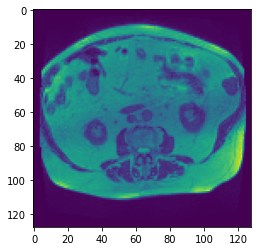

In [ ]:
test_generator = dataGeneratorCoco(images_test, classes, coco_val,input_image_size, batch_size, mask_type)

i = 0
for img, mask in test_generator:
  print(i)
  print(images_test[i]['file_id'])
  print(images_test[i]['file_name'])
  if(i==1):
    plt.imshow(img[i][:, :,0])
    break
  i+=1
print(i) 

In [158]:
img_s, mask_s = next(test_generator)

preds = model.predict(img_s)

In [159]:


fig = plt.figure(figsize=(50, 40))
gs = gridspec.GridSpec(nrows=len(img_s), ncols=3)
colors = ['yellow','green','red']
labels = [ "Small Bowel","Large Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])
flag=False
for i in range(0,15):

    images, mask = img_s[i], mask_s[i]
    
    sample_img=images/255.
    mask1=mask[:,:,0]
    mask2=mask[:,:,1]
    mask3=mask[:,:,2]

    pre=preds[i]
    predict1=pre[:,:,0]
    predict1= (predict1 > 0.5).astype(np.float32)
    predict1 = np.array(predict1)
    predict2=pre[:,:,1]
    predict2= (predict2 > 0.5).astype(np.float32)
    predict2 = np.array(predict2)    
    predict3=pre[:,:,2]    
    predict3= (predict3 > 0.5).astype(np.float32)
    predict3 = np.array(predict3)        


    ax0 = fig.add_subplot(gs[i, 0])
    ax1 = fig.add_subplot(gs[i, 1])
    ax2 = fig.add_subplot(gs[i, 2])

    im = ax0.imshow(sample_img[:,:,0], cmap='gray')


    if(flag == False):
      flag= True
      ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
      ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
      ax2.set_title("predicted Mask", fontsize=15, weight='bold', y=1.02)
      plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')


    l0 = ax1.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)

    l0 = ax2.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)    
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

plt.subplots_adjust(left=0.11, bottom=0.08, right=0.3, top=0.92, wspace=0.01, hspace=0.08)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


In [136]:
num_batches = int(len(test_df)/batch_size)
num_batches

423